# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

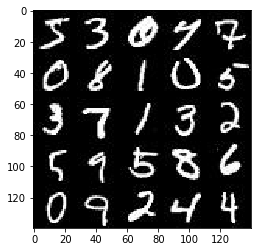

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

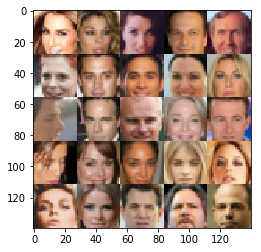

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_image')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input_image, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [16]:
def discriminator(images, reuse=False):
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_norm = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch_norm, batch_norm)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):

        fullCon1 = tf.layers.dense(z, 4*4*512)

        fullCon1 = tf.reshape(fullCon1, (-1, 4, 4, 512))
        batch_norm1 = tf.layers.batch_normalization(fullCon1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        Conv1 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        batch_norm2 = tf.layers.batch_normalization(Conv1, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        Conv2 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(Conv2, training=is_train)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')
        # show the final training result
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 7.5092
Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 3.1521
Epoch 1/2... Discriminator Loss: 0.0502... Generator Loss: 4.3935
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.4947
Epoch 1/2... Discriminator Loss: 0.1296... Generator Loss: 2.9904
Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.3660
Epoch 1/2... Discriminator Loss: 0.0692... Generator Loss: 5.2830
Epoch 1/2... Discriminator Loss: 0.2373... Generator Loss: 2.2942
Epoch 1/2... Discriminator Loss: 0.3558... Generator Loss: 2.3530
Epoch 1/2... Discriminator Loss: 0.2328... Generator Loss: 4.9315


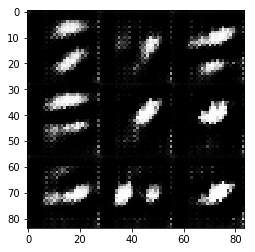

Epoch 1/2... Discriminator Loss: 1.9747... Generator Loss: 0.3211
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 2.1745
Epoch 1/2... Discriminator Loss: 0.2204... Generator Loss: 3.3588
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 0.9851
Epoch 1/2... Discriminator Loss: 0.1750... Generator Loss: 2.2518
Epoch 1/2... Discriminator Loss: 0.1873... Generator Loss: 7.3913
Epoch 1/2... Discriminator Loss: 0.0751... Generator Loss: 3.4979
Epoch 1/2... Discriminator Loss: 0.0295... Generator Loss: 4.2989
Epoch 1/2... Discriminator Loss: 0.0321... Generator Loss: 4.2635
Epoch 1/2... Discriminator Loss: 0.1113... Generator Loss: 3.2871


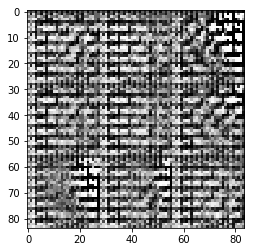

Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 1.5020
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 0.2219... Generator Loss: 2.3676
Epoch 1/2... Discriminator Loss: 0.3679... Generator Loss: 2.0143
Epoch 1/2... Discriminator Loss: 2.0222... Generator Loss: 6.2572
Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 3.3419
Epoch 1/2... Discriminator Loss: 0.2468... Generator Loss: 2.1611
Epoch 1/2... Discriminator Loss: 0.1015... Generator Loss: 3.6390
Epoch 1/2... Discriminator Loss: 0.1596... Generator Loss: 3.4322
Epoch 1/2... Discriminator Loss: 0.0613... Generator Loss: 5.1659


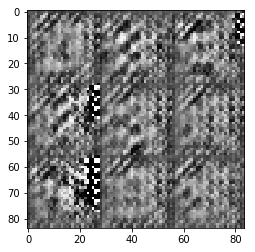

Epoch 1/2... Discriminator Loss: 0.0266... Generator Loss: 5.7645
Epoch 1/2... Discriminator Loss: 0.2213... Generator Loss: 2.5855
Epoch 1/2... Discriminator Loss: 0.0164... Generator Loss: 5.9708
Epoch 1/2... Discriminator Loss: 6.8047... Generator Loss: 11.3423
Epoch 1/2... Discriminator Loss: 0.2735... Generator Loss: 2.8362
Epoch 1/2... Discriminator Loss: 2.5459... Generator Loss: 0.1295
Epoch 1/2... Discriminator Loss: 2.5260... Generator Loss: 2.3468
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 3.4310
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 3.3858
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 3.7025


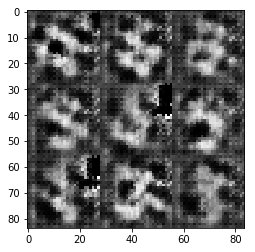

Epoch 1/2... Discriminator Loss: 0.5403... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 2.8355
Epoch 1/2... Discriminator Loss: 0.0771... Generator Loss: 4.6762
Epoch 1/2... Discriminator Loss: 0.1853... Generator Loss: 2.9627
Epoch 1/2... Discriminator Loss: 0.0773... Generator Loss: 3.8142
Epoch 1/2... Discriminator Loss: 0.1010... Generator Loss: 3.6472
Epoch 1/2... Discriminator Loss: 0.1959... Generator Loss: 2.2434
Epoch 1/2... Discriminator Loss: 0.0213... Generator Loss: 4.9745
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.7949
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 8.8857


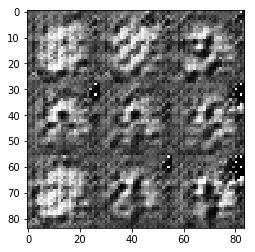

Epoch 1/2... Discriminator Loss: 0.2189... Generator Loss: 3.2336
Epoch 1/2... Discriminator Loss: 0.3905... Generator Loss: 2.1090
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 1.6304
Epoch 1/2... Discriminator Loss: 0.3009... Generator Loss: 2.2782
Epoch 1/2... Discriminator Loss: 0.3757... Generator Loss: 1.7691
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 3.8314
Epoch 1/2... Discriminator Loss: 2.9226... Generator Loss: 0.1051
Epoch 1/2... Discriminator Loss: 0.3366... Generator Loss: 2.6583
Epoch 1/2... Discriminator Loss: 0.2092... Generator Loss: 2.7103
Epoch 1/2... Discriminator Loss: 0.0676... Generator Loss: 3.7359


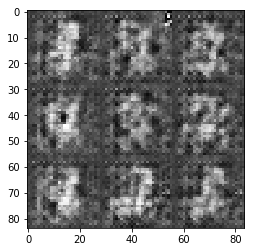

Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 5.7779
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 4.1667
Epoch 2/2... Discriminator Loss: 1.4747... Generator Loss: 1.5238
Epoch 2/2... Discriminator Loss: 0.3100... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 2.4441... Generator Loss: 0.1417
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 1.3865
Epoch 2/2... Discriminator Loss: 2.8755... Generator Loss: 0.1008
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.4141
Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.1505


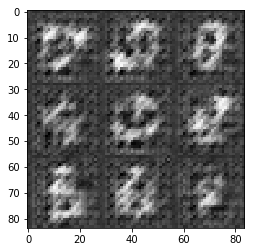

Epoch 2/2... Discriminator Loss: 0.1028... Generator Loss: 3.1476
Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 0.1666... Generator Loss: 2.1555
Epoch 2/2... Discriminator Loss: 0.0645... Generator Loss: 4.0920
Epoch 2/2... Discriminator Loss: 0.3224... Generator Loss: 1.7890
Epoch 2/2... Discriminator Loss: 0.0175... Generator Loss: 5.9623
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 1.6343
Epoch 2/2... Discriminator Loss: 2.1095... Generator Loss: 0.8461


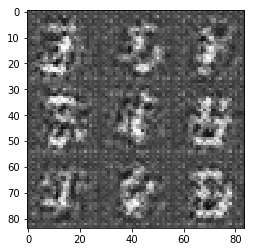

Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 2.9278
Epoch 2/2... Discriminator Loss: 0.4928... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 0.4724... Generator Loss: 1.1870
Epoch 2/2... Discriminator Loss: 0.1447... Generator Loss: 2.5773
Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 2.5360
Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 0.3957... Generator Loss: 1.6370
Epoch 2/2... Discriminator Loss: 0.2569... Generator Loss: 1.6574
Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 2.2714
Epoch 2/2... Discriminator Loss: 0.2723... Generator Loss: 1.6873


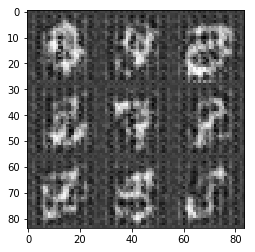

Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.0284
Epoch 2/2... Discriminator Loss: 0.0336... Generator Loss: 4.6606
Epoch 2/2... Discriminator Loss: 0.1624... Generator Loss: 2.1345
Epoch 2/2... Discriminator Loss: 0.2240... Generator Loss: 1.9684
Epoch 2/2... Discriminator Loss: 0.0304... Generator Loss: 4.3228
Epoch 2/2... Discriminator Loss: 0.1658... Generator Loss: 2.1934
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 7.1267
Epoch 2/2... Discriminator Loss: 0.0195... Generator Loss: 7.0777
Epoch 2/2... Discriminator Loss: 0.0121... Generator Loss: 7.0216
Epoch 2/2... Discriminator Loss: 0.1219... Generator Loss: 2.6684


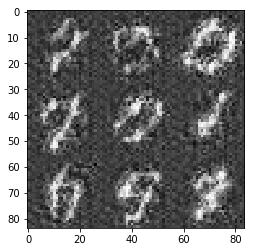

Epoch 2/2... Discriminator Loss: 0.0329... Generator Loss: 4.0923
Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 5.0626
Epoch 2/2... Discriminator Loss: 0.0109... Generator Loss: 5.6121
Epoch 2/2... Discriminator Loss: 0.0115... Generator Loss: 5.6474
Epoch 2/2... Discriminator Loss: 0.1596... Generator Loss: 2.1522
Epoch 2/2... Discriminator Loss: 3.7075... Generator Loss: 0.1215
Epoch 2/2... Discriminator Loss: 2.1218... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.6844... Generator Loss: 0.3334
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.4539
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 2.8940


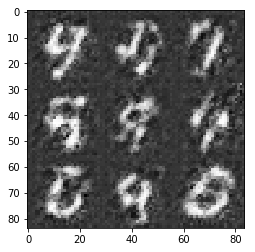

Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 2.7018
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 2.0192
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 1.7130
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.8937
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 3.4498
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.7162
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.7181
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 0.9535


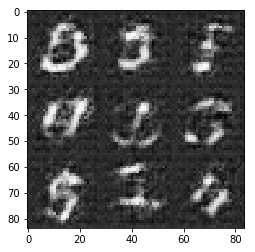

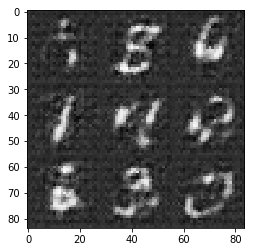

In [34]:
batch_size = 100
z_dim = 100
learning_rate = 0.004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 4.7087
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 6.0110
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 2.6550
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 3.8295
Epoch 1/1... Discriminator Loss: 0.0733... Generator Loss: 6.4131
Epoch 1/1... Discriminator Loss: 0.2829... Generator Loss: 1.9760
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 8.4058


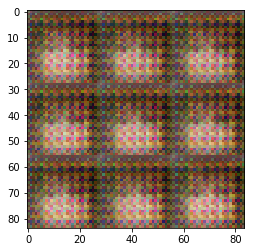

Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 3.6251
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 0.1285... Generator Loss: 3.3985
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.5150
Epoch 1/1... Discriminator Loss: 0.1039... Generator Loss: 3.5056
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 3.5456
Epoch 1/1... Discriminator Loss: 0.1039... Generator Loss: 3.0135
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 3.3903
Epoch 1/1... Discriminator Loss: 0.1159... Generator Loss: 3.4679
Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 4.5051


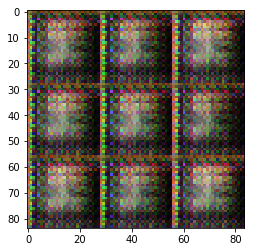

Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 3.4289
Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 3.3752
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.4240
Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 3.4422
Epoch 1/1... Discriminator Loss: 0.0436... Generator Loss: 4.1655
Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 4.4217
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 16.1431
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 4.1509
Epoch 1/1... Discriminator Loss: 0.0852... Generator Loss: 4.7781
Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 9.1090


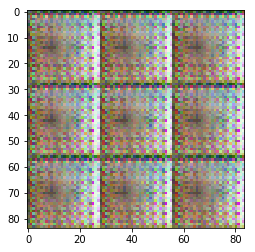

Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 5.0819
Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 3.3366
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 1.9928
Epoch 1/1... Discriminator Loss: 0.1334... Generator Loss: 6.5522
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 5.1467
Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 11.4055
Epoch 1/1... Discriminator Loss: 2.8762... Generator Loss: 0.0777
Epoch 1/1... Discriminator Loss: 4.6870... Generator Loss: 0.0153
Epoch 1/1... Discriminator Loss: 2.1531... Generator Loss: 0.1492
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 5.1559


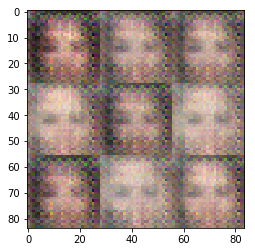

Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 5.3689
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 3.0497
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 2.4171
Epoch 1/1... Discriminator Loss: 0.0932... Generator Loss: 3.5873
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 7.7544
Epoch 1/1... Discriminator Loss: 0.0664... Generator Loss: 4.8567
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 7.9609
Epoch 1/1... Discriminator Loss: 0.0690... Generator Loss: 5.1666
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 5.7368


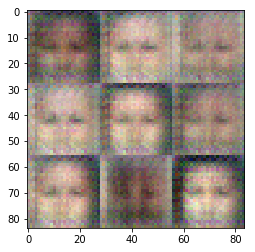

Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 3.0456
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 8.0034
Epoch 1/1... Discriminator Loss: 0.2308... Generator Loss: 1.9735
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 5.0829
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 4.1408
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 4.4493
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 7.5795


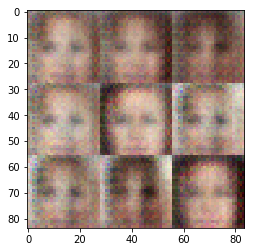

Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 5.6167
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 0.2509
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 4.7613
Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 9.5139
Epoch 1/1... Discriminator Loss: 0.0265... Generator Loss: 7.3442
Epoch 1/1... Discriminator Loss: 2.6922... Generator Loss: 0.0825
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 0.1462... Generator Loss: 10.1032
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 8.8330
Epoch 1/1... Discriminator Loss: 0.0431... Generator Loss: 12.8318


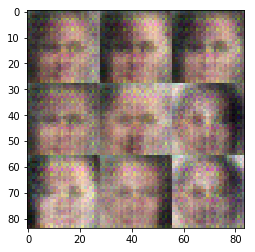

Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 4.0956
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 4.3610
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 6.1325
Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 4.2736
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 6.0563
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 7.1025
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 6.7877
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 6.1989


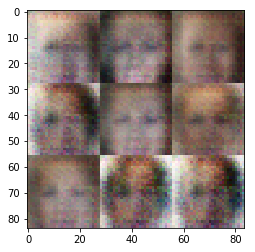

Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 4.7948
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 3.9581
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 9.5928
Epoch 1/1... Discriminator Loss: 0.1099... Generator Loss: 8.9054
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 8.7793
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 10.9807
Epoch 1/1... Discriminator Loss: 1.8643... Generator Loss: 0.2005
Epoch 1/1... Discriminator Loss: 0.2455... Generator Loss: 2.5093
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 4.5112


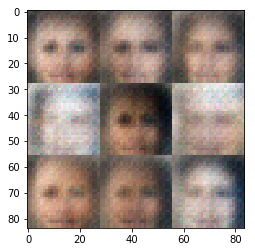

Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 13.7407
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 5.5853
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 8.5763
Epoch 1/1... Discriminator Loss: 0.1441... Generator Loss: 9.4174
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.6126
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 1.9984... Generator Loss: 0.1822
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 12.1943
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 4.5969


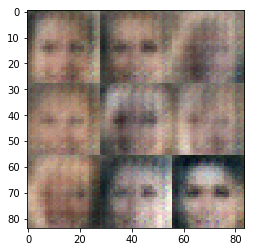

Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 10.8122
Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 4.6269
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 11.5597
Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 5.6531
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 8.4371
Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 10.8456
Epoch 1/1... Discriminator Loss: 0.0520... Generator Loss: 4.1935
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 10.2572
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 5.0112


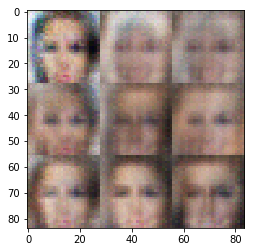

Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 12.5871
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 3.1964
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 5.4352
Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 12.9843
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 4.8651
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 11.5284
Epoch 1/1... Discriminator Loss: 0.3230... Generator Loss: 12.5864
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 6.1059
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 7.3565
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 6.9532


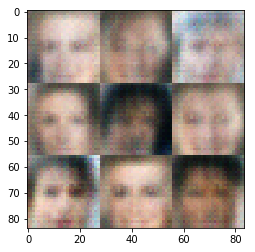

Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 6.9130
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 13.9562
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 8.0384
Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 5.4986
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 8.2546
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 9.7579
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 6.2581
Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 3.5161
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 7.2510
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 2.3311


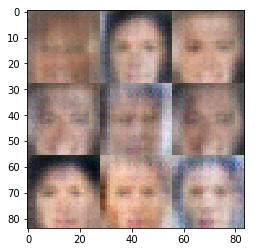

Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 5.0052
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 3.1168
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 4.0740
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 7.7650
Epoch 1/1... Discriminator Loss: 0.0396... Generator Loss: 6.6161
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 12.4800
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 11.8540
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 9.7906
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 8.7405


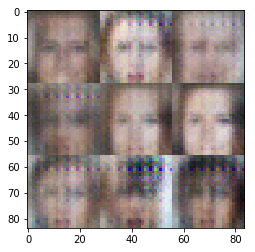

Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 1.6386
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 9.9850
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 6.9902
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 9.6519
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 2.9742
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.9997
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 6.3005
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 10.5351
Epoch 1/1... Discriminator Loss: 0.0410... Generator Loss: 5.0852


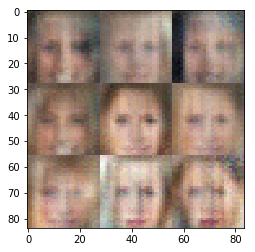

Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 7.2589
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 6.0556
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 7.8920
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 4.9656
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 1.4711
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 10.2417
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 5.2572


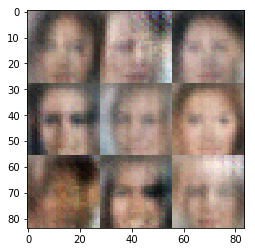

In [44]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.